<a href="https://colab.research.google.com/github/K100NUNES/K100NUNES-Tech-Chalenge-Fase-1-5IADT/blob/main/IADT_Fase_1_Tech_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Previsão de Custos Médicos Individuais** (Modelo preditivo de regressão)

**Introdução**

O acesso à saúde é um tema crítico em qualquer sociedade, e entender os fatores que influenciam os custos de planos médicos pode beneficiar tanto pacientes quanto operadoras. Este projeto tem como objetivo prever os encargos médicos de um indivíduo com base em características como idade, gênero, índice de massa corporal (IMC), número de filhos, tabagismo e região. A abordagem se apoia em técnicas de regressão aprendidas ao longo da fase 1 do curso de IA para Devs, aliadas a boas práticas de pré-processamento e análise estatística para garantir previsões confiáveis e interpretáveis.

Começo importando as bibliotecas necessárias...*texto em itálico*

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# **Exploração de dados**


Baixando e lendo o arquivo .parquet diretamente do Hugginface

In [156]:
url = "https://huggingface.co/datasets/rahulvyasm/medical_insurance_data/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet"

try:
    df = pd.read_parquet(url)
    print("Dados carregados com sucesso.")
except Exception as e:
    print(f"Erro ao carregar os dados: {e}")

df.head(10)

Dados carregados com sucesso.


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [157]:
#Quantidade de registros e colunas
df.shape

(2772, 7)

In [158]:
#Verificando possíveis linhas duplicadas
print(df[df.duplicated()])

      age     sex     bmi  children smoker     region      charges
581    19    male  30.590         0     no  northwest   1639.56310
1338   23    male  34.400         0     no  southwest   1826.84300
1339   56  female  39.820         0     no  southeast  11090.71780
1340   27    male  42.130         0    yes  southeast  39611.75770
1341   19    male  24.600         1     no  southwest   1837.23700
...   ...     ...     ...       ...    ...        ...          ...
2767   47  female  45.320         1     no  southeast   8569.86180
2768   21  female  34.600         0     no  southwest   2020.17700
2769   19    male  26.030         1    yes  northwest  16450.89470
2770   23    male  18.715         0     no  northwest  21595.38229
2771   54    male  31.600         0     no  southwest   9850.43200

[1435 rows x 7 columns]


In [159]:
#Removendo as duplicatas
df = df.drop_duplicates()

In [160]:
#Entendendo a estrutura do conjunto de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


Todas as 7 colunas têm 1337 valores não nulos, o que corresponde exatamente ao número de entradas após remoção de duplicatas. Não há dados faltantes, portanto podemos prosseguir sem tratamento adicional.

In [161]:
#Obtenho uma descrição estatística de todas as colunas (incluindo as categóricas)
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1337,1337.000000,1337.000000,1337,1337,1337.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,675,NaN,NaN,1063,364,NaN
mean,39.222139,NaN,30.663452,1.095737,NaN,NaN,13279.121487
std,14.044333,NaN,6.100468,1.205571,NaN,NaN,12110.359656
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.290000,0.000000,NaN,NaN,4746.344000
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9386.161300
75%,51.000000,NaN,34.700000,2.000000,NaN,NaN,16657.717450


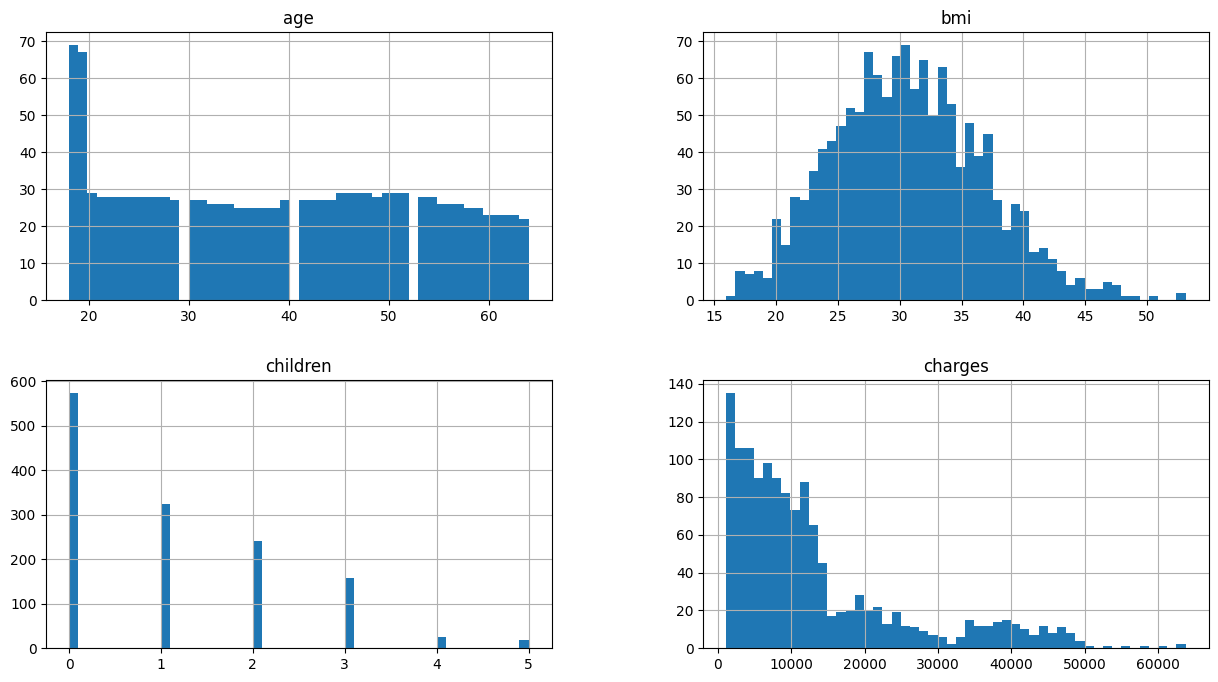

In [162]:
df.hist(bins=50, figsize=(15, 8))
plt.show()

**Idade (age):** Distribuição não uniforme, com picos aos 18–19 anos.
Provavelmente por regras de entrada no plano (ex: jovem adulto).

**IMC (bmi):** Distribuição quase normal (gaussiana), centrada entre 28–32.
Pode indicar sobrepeso como padrão entre os segurados.

**Filhos (children):** Fortemente concentrada em 0 e 1 filho.
Há poucos casos com 4 ou 5 filhos — possível outlier ou nicho específico.

**Encargos (charges):** Distribuição assimétrica à direita (right-skewed).
Muitos valores baixos, poucos valores muito altos (outliers).

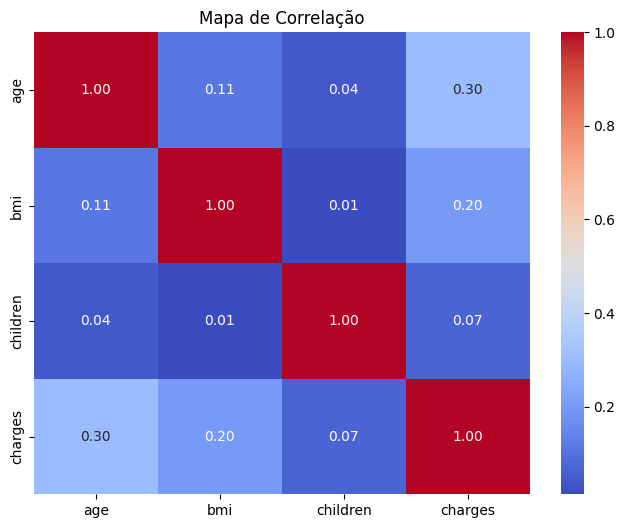

In [163]:
# Mapa de correlação
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlação')
plt.show()

**Idade:** Correlação moderada positiva – pessoas mais velhas tendem
a ter custos mais altos.

**IMC:** Correlação leve – IMC mais alto pode elevar encargos.

**Filhos:** Quase nula – número de filhos tem pouco impacto direto.

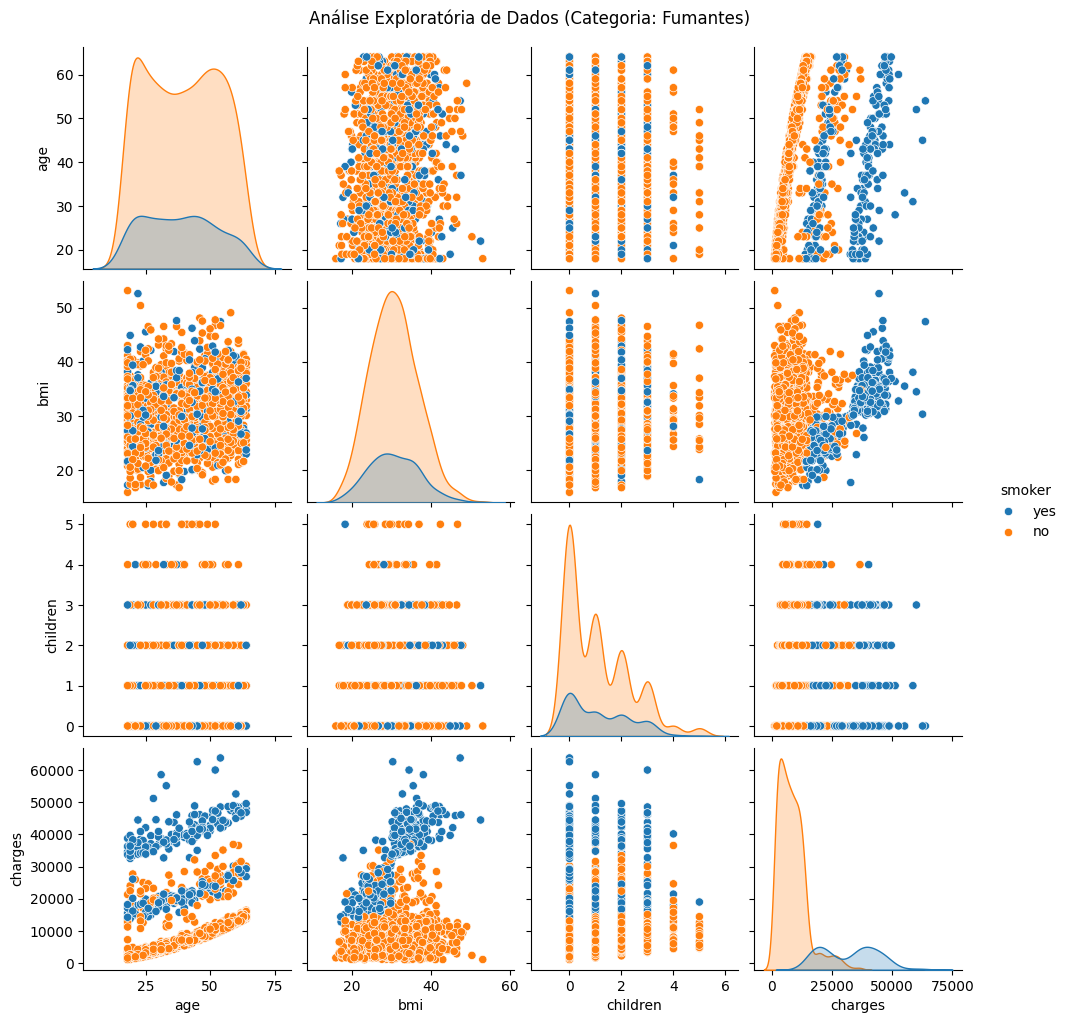

In [164]:
# Análise exploratória usando o pairplot
sns.pairplot(df, hue='smoker')
plt.suptitle('Análise Exploratória de Dados (Categoria: Fumantes)', y=1.02)
plt.show()

O gráfico reforça visualmente que ser fumante é o principal fator associado a encargos elevados, superando o impacto isolado de idade ou IMC.


# **Pré processamento**

In [165]:
#Duplicando o dataframe
df_process = df.copy()

In [166]:
#convertendo as colunas categóricas em 0/1
df_process = pd.get_dummies(df, columns=['sex', 'region', 'smoker'], drop_first=True)

#forçando 0/1 para as que ficaram como boolean
cols_bool = df_process.select_dtypes(include='bool').columns
df_process[cols_bool] = df_process[cols_bool].astype(int)

df_process.head(10)


,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19,27.900,0,16884.92400,0,0,0,1,1
1,18,33.770,1,1725.55230,1,0,1,0,0
2,28,33.000,3,4449.46200,1,0,1,0,0
3,33,22.705,0,21984.47061,1,1,0,0,0
4,32,28.880,0,3866.85520,1,1,0,0,0
5,31,25.740,0,3756.62160,0,0,1,0,0
6,46,33.440,1,8240.58960,0,0,1,0,0
7,37,27.740,3,7281.50560,0,1,0,0,0
8,37,29.830,2,6406.41070,1,0,0,0,0
9,60,25.840,0,28923.13692,0,1,0,0,0


In [167]:
#Novamente, entendendo a estrutura do conjunto de dados
df_process.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   bmi               1337 non-null   float64
 2   children          1337 non-null   int64  
 3   charges           1337 non-null   float64
 4   sex_male          1337 non-null   int64  
 5   region_northwest  1337 non-null   int64  
 6   region_southeast  1337 non-null   int64  
 7   region_southwest  1337 non-null   int64  
 8   smoker_yes        1337 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 104.5 KB


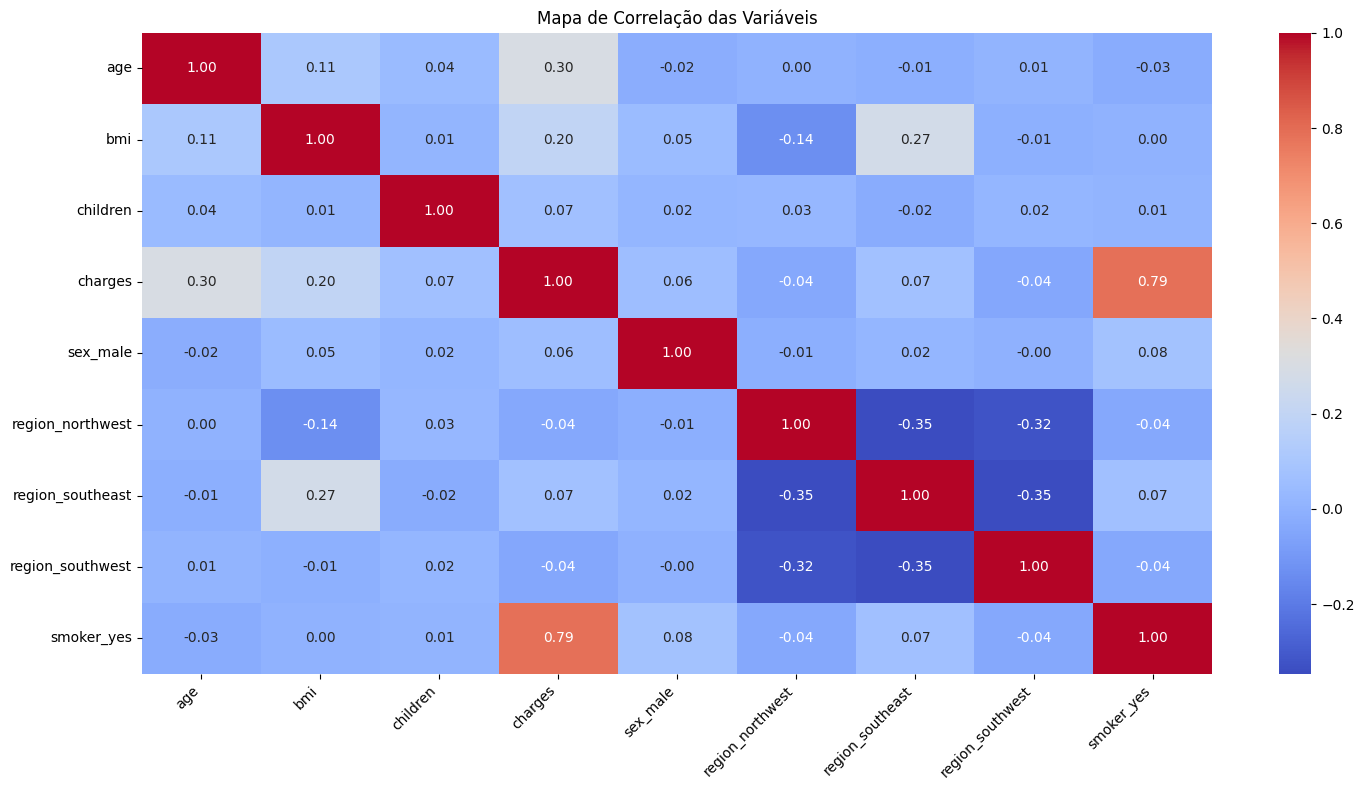

Top 5 variáveis mais correlacionadas com encargos:
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
Name: charges, dtype: float64


In [168]:
#Analisando as correlações
corr = df_process.corr(numeric_only=True)

# Gera o heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlação das Variáveis')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Top 5 variáveis mais correlacionadas aos encargos
top_corr = corr['charges'].drop('charges').abs().sort_values(ascending=False).head()
print("Top 5 variáveis mais correlacionadas com encargos:")
print(top_corr)

A análise de correlação indicou que a variável **smoker_yes** (fumantes = sim) apresenta a relação mais forte com os **encargos** médicos (coef. 0.79), revelando um impacto expressivo do tabagismo nos custos de saúde. Variáveis como **idade** (coef. 0.30) e **IMC** (coef. 0.20) também mostraram correlação positiva, embora mais moderada. Já **filhos**, **gênero** e **região** tiveram correlação fraca, com influência limitada sobre os **encargos**.

# Modelo Preditivo (Regressões)

In [169]:
# Separação entre variáveis independentes e alvo
X = df_process.drop('charges', axis=1)
y = df_process['charges']

# Divisão em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizando os dados pré-regressão
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# df com nomes de colunas para a Regressão Linear (evitar o warn)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

In [170]:
# Função reutilizável para printar os resultados
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("R² Score:", r2_score(y_true, y_pred))

# Linear
lr = LinearRegression()
lr.fit(X_train_scaled_df, y_train)
y_pred_lr = lr.predict(X_test_scaled_df)
evaluate_model("Linear", y_test, y_pred_lr)

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
evaluate_model("KNN", y_test, y_pred_knn)

# Árvore de Decisão
tree = DecisionTreeRegressor(max_depth=6, random_state=42)
tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)
evaluate_model("Árvore de Decisão", y_test, y_pred_tree)


Linear
MAE: 4177.045561036325
MSE: 35478020.675235614
R² Score: 0.8069287081198011

KNN
MAE: 3476.1802033619406
MSE: 29932536.693817254
R² Score: 0.8371072168419843

Árvore de Decisão
MAE: 2813.9783609924934
MSE: 23850729.632342305
R² Score: 0.8702043943050076


O modelo de Regressão Linear apresentou um bom desempenho, com R² de 0.81 e MAE de R$ 4.177.
No entanto, os modelos baseados em KNN e, principalmente, Árvore de Decisão superaram seus resultados.

A Árvore de Decisão obteve o melhor desempenho geral, com erro médio de R$ 2.814 e R² de 0.87, indicando maior precisão na previsão dos encargos médicos.

Essa escolha é reforçada pela natureza não linear dos dados, evidenciada nas análises exploratórias anteriores — como a distribuição assimétrica dos encargos e a forte influência do tabagismo.

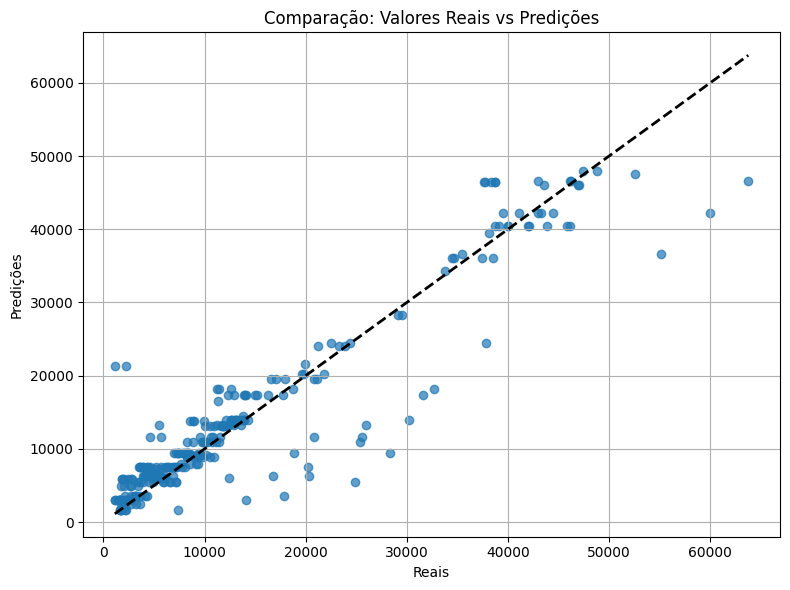

In [171]:
#Visualização: Reais vs Predições
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tree, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Reais')
plt.ylabel('Predições')
plt.title('Comparação: Valores Reais vs Predições')
plt.grid(True)
plt.tight_layout()
plt.show()

O gráfico evidencia que o modelo de Regressão de Árvore de Decisão teve boa performance.

A linha preta tracejada representa a linha ideal onde os valores previstos seriam exatamente iguais aos reais. A maior parte dos pontos está próxima dessa linha, o que indica que o modelo tem bom poder preditivo.

# **Conclusão**

Foram testados três modelos de regressão: Linear, KNN e Árvore de Decisão. A regressão linear teve um bom desempenho (R² = 0.81, MAE = R$ 4.177), mas foi superada pelos modelos de regressão não lineares: KNN e Árvore de Decisão.

O melhor resultado foi da Árvore de Decisão, com R² = 0.87 e MAE = R$ 2.814, mostrando que ela faz previsões mais precisas dos encargos médicos.

As variáveis mais importantes foram o status de fumante, idade e IMC. Isso indica que fatores de saúde e estilo de vida têm forte impacto nos custos.

Com base nesses resultados, o modelo de Árvore de Decisão é o mais indicado para prever custos médicos de forma prática e confiável.

